# Compare model polysome counts to experimental data 

The model produces an exact account of polysomes on the mRNA. We can use this to compare it to ribosomal profiling data - which give very similar results - to validate our output. Here we look at the run-off simulation after the experiment performed by Presnyak 2015. For this experiment we let the cell go to a steady state before and we use this state to compare it with experimental data.

In [398]:
from translation.analyze import *
import collections as col
import numpy as np
import cPickle as pkl
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

In [399]:
%matplotlib inline

Load the steady state and the run-off state after glucose starvation. Pickle files written with `pypy` must be edited before. Each occurrence of `_numpypy.multiarray` must be changed to `cnumpy.core.multiarray`.

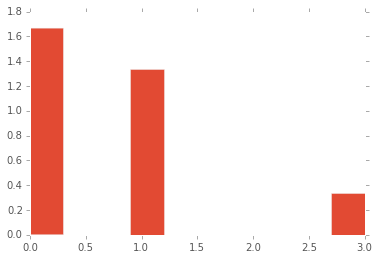

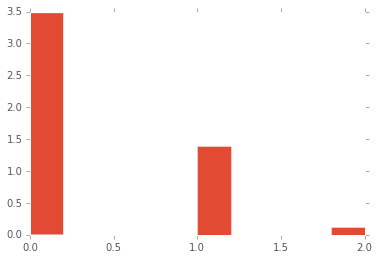

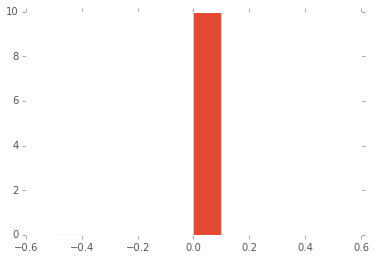

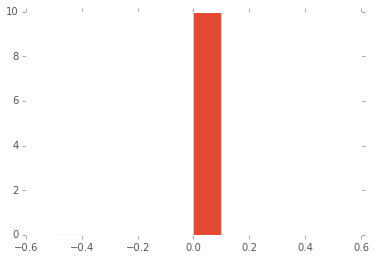

In [396]:
steady = pkl.load(open("../results/steady_state_20150707_1229_1999s.p", "rb"))
plot_polysome_histograms(steady, subset=("YJL124C","YHL015W"))
run_off = pkl.load(open("../results/glucose_starvation_after_steady_20150707_1230_0599s.p", "rb"))
plot_polysome_histograms(run_off, subset=("YJL124C","YHL015W"))
plt.show()

In [559]:
results.loc[["YHL015W","YJL124C"],:]

,ribosome_count,mrna_count,max_ribos,mrna_length
YHL015W,64,194,2,366
YJL124C,7,10,3,519


In [400]:
steady_ribos = get_polysome_histogram(steady)
ribos = [sum(steady_ribos[x]) for x in steady_ribos]
max_ribos = [max(steady_ribos[x]) for x in steady_ribos]
mrna_count = [len(steady_ribos[x]) for x in steady_ribos]

In [447]:
steady_ribos

{'YBR177C': [2, 1, 0, 3, 1, 2, 2, 1, 5, 0],
 'YIL140W': [2],
 'YLR268W': [0, 0, 0],
 'YIR004W': [1, 1, 3, 2, 2, 0, 1, 3, 2],
 'YAL008W': [0, 0, 0],
 'YOR043W': [1, 0, 0, 1, 0, 2, 3, 3, 1, 2, 3, 2, 3, 1, 1, 1, 2],
 'YJL122W': [1, 0, 0, 0, 0, 0, 2, 2, 0, 0],
 'YCR093W': [4, 4, 7, 9, 10, 13, 8, 5, 5, 5],
 'YLR244C': [3,
  2,
  1,
  0,
  1,
  2,
  0,
  1,
  0,
  0,
  4,
  1,
  0,
  0,
  3,
  1,
  3,
  0,
  2,
  0,
  2,
  1,
  1,
  2,
  1,
  0,
  1,
  0],
 'YPL144W': [0, 1, 1],
 'YJR084W': [1, 1, 3, 2],
 'YBR135W': [0, 0],
 'YBR004C': [1, 3, 0, 1, 3],
 'YBR160W': [0, 1, 0, 0, 0, 0, 1, 2],
 'YHR007C': [2,
  2,
  0,
  2,
  2,
  1,
  1,
  3,
  1,
  1,
  0,
  4,
  2,
  2,
  1,
  1,
  0,
  1,
  1,
  3,
  0,
  1,
  1,
  0,
  2,
  0,
  1,
  0,
  0,
  0],
 'YLR197W': [0,
  2,
  2,
  0,
  1,
  4,
  1,
  0,
  2,
  0,
  3,
  3,
  2,
  0,
  2,
  1,
  1,
  1,
  1,
  2,
  0,
  1,
  3,
  1,
  0,
  1,
  3,
  2,
  1,
  1,
  2,
  3,
  3,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  0,
  2,
  2,
  1,
  0,
 

To get an overview we calculate some aggregates of the whole data-set.

In [401]:
results = pd.DataFrame(np.array([ribos, 
                       mrna_count, 
                       max_ribos]).T,
             index = steady_ribos.keys(),
            columns = ["ribosome_count",
                      "mrna_count",
                      "max_ribos"])
transcripts = steady["transcriptome"]
seq_length = {}
for mrna in transcripts:
    if mrna.geneID in seq_length:
        pass
    else:
        seq_length[mrna.geneID] = len(mrna.sequence)
mrna_length = pd.DataFrame(seq_length, columns=seq_length.keys(), index=["mrna_length"]).T

This tells us the steady state distribution of polysomes:

(array([  1.60650000e+04,   1.34660000e+04,   7.74400000e+03,
          3.72300000e+03,   1.73200000e+03,   8.94000000e+02,
          3.95000000e+02,   2.11000000e+02,   1.05000000e+02,
          5.30000000e+01,   3.10000000e+01,   1.30000000e+01,
          1.00000000e+01,   9.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Patch objects>)

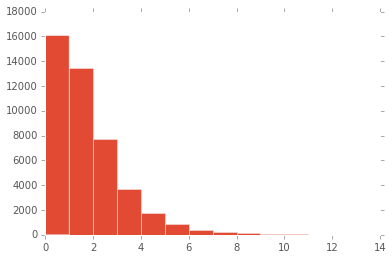

In [402]:
import itertools
ribos_per_mrna = list(itertools.chain.from_iterable(steady_ribos.values()))
plt.hist(ribos_per_mrna, bins=range(15))

It is clear that we see very few true polysomes and many empty mRNAs. This is surprising to me. Can this be seen in experiments as well?

In [403]:
results = results.join(mrna_length)

In [404]:
results.head()

,ribosome_count,mrna_count,max_ribos,mrna_length
YBR177C,17,10,5,1356
YIL140W,2,1,2,2472
YLR268W,0,3,0,645
YIR004W,15,9,3,1299
YAL008W,0,3,0,597


# Analyze simulation results

We have some clear correllation in our data, but nothing surprising.

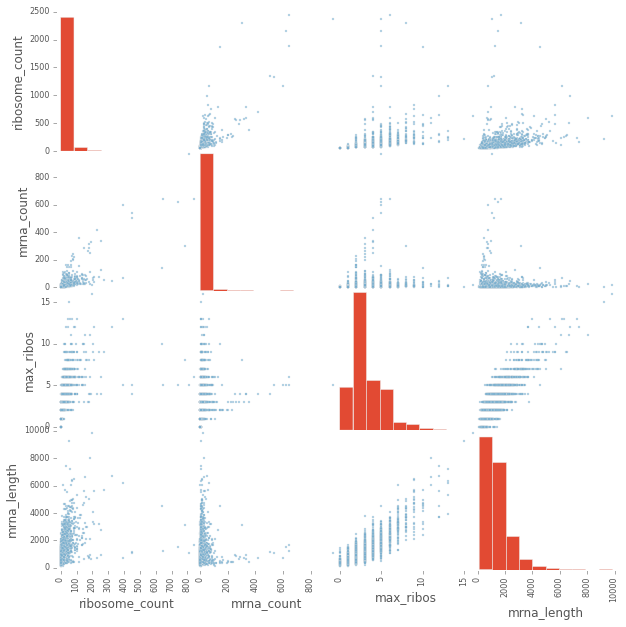

In [405]:
ax = pd.scatter_matrix(results, figsize=(10,10))

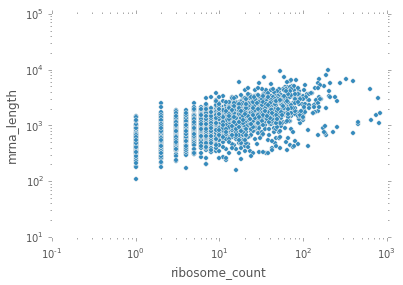

In [406]:
results[results.ribosome_count > 0].plot("ribosome_count", "mrna_length", kind="scatter", loglog=True)

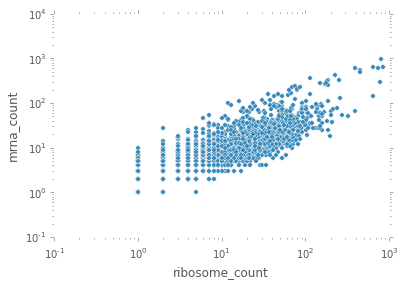

In [407]:
results[results.ribosome_count > 0].plot("ribosome_count", "mrna_count", kind="scatter", loglog=True)

## Experimental Data

Data from Ingolia 2009 was not easily accessible, so I used ribo profiling data from Pop 2014 ([GSEGSE63789](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1557447))

In [408]:
ribo_profiling = pd.read_csv("../data/GSE63789_counts_wt.txt", sep="\t")

In [409]:
ribo_profiling.head()

,#Name,Length,Sum-mRNA,Sum-FP,FP
0,YAL001C,1161,17547,1227,1 10 1 1 5 5 0 2 0 0 0 0 2 0 0 0 1 3 3 0 0 0 0...
1,YAL002W,1275,10012,497,0 9 1 0 2 0 0 0 0 0 0 0 0 1 0 3 0 0 0 1 0 0 1 ...
2,YAL003W,207,331142,119930,21 3159 146 29 58 332 44 268 98 92 52 30 175 7...
3,YAL007C,216,33005,4104,2 92 39 3 11 6 2 0 3 5 8 0 0 7 8 23 10 23 4 28...
4,YAL008W,199,6247,1218,0 19 1 0 0 0 6 0 8 22 5 17 2 8 8 0 14 8 7 9 21...


The table is a preprocessed outcome of the experiments and holds all the information we need:
    - #Name: gene name
    - Length: seq length
    - Sum-mRNA: total measured mRNA amounts
    - Sum-FP: total measured foot prints
    - FP: foot prints per position (notation is unclear)

To get a measure of Ribosome density on the mRNA we simply take $\frac{mRNA}{FP}$ and normalize so it is centered on zero, like presented in Ingolia 2009. Maybe there are better ways to estimate this out there.

In [410]:
ribo_profiling = ribo_profiling.drop("FP", axis=1)

In [411]:
ratio_median = np.median(ribo_profiling["Sum-FP"]/ribo_profiling["Sum-mRNA"])

The distribution looks similar to the one given by Ingolia. So there is quite some difference between translation efficiency.

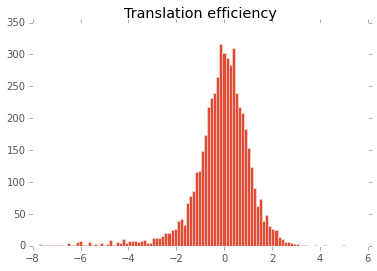

In [412]:
ax = np.log2((ribo_profiling["Sum-FP"]/ribo_profiling["Sum-mRNA"])/ratio_median).hist(bins=100)
ax.set_title("Translation efficiency")

## Single cell transcriptome

Zenklusen et al. 2008 measured the total mRNA per cell to be around 60000 transcripts, so we limit the number to 60000 and sample the genes according to the relative amount of mRNA. A similar method was used by Shah 2012.

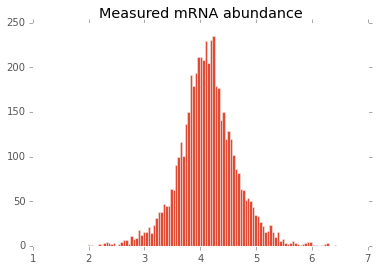

In [413]:
ax = np.log10(ribo_profiling["Sum-mRNA"]).hist(bins=100)
ax.set_title("Measured mRNA abundance")

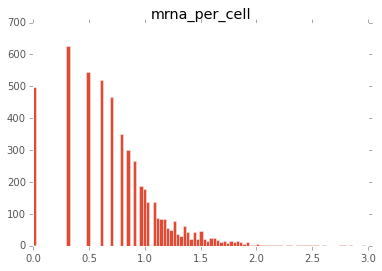

In [414]:
n_genes = ribo_profiling.shape[0]
mrna_prob = ribo_profiling["Sum-mRNA"]/ribo_profiling["Sum-mRNA"].sum()
mrna_sample = np.random.choice(np.array(ribo_profiling["#Name"]), size= 60000-n_genes, p=np.array(mrna_prob))
mrna_sample = np.concatenate([mrna_sample, np.array(ribo_profiling["#Name"])])
transcriptome = pd.DataFrame(pd.Series(col.Counter(mrna_sample)), columns=["mrna_per_cell"])
ax = np.log10(transcriptome).hist(bins = 100)

### Save sample to pickle file

In [415]:
transcriptome.sum()

mrna_per_cell    60000
dtype: int64

In [416]:
pkl.dump(dict(col.Counter(mrna_sample)), open("../parameters/transcriptome_60000.p", "wb"))

### Compare experiment and simulation 

In [417]:
ribo_profiling.index = ribo_profiling["#Name"]
ribo_profiling = ribo_profiling.join(transcriptome)

,Sum-mRNA,mrna_per_cell
Sum-mRNA,1.000000,0.995269
mrna_per_cell,0.995269,1.000000


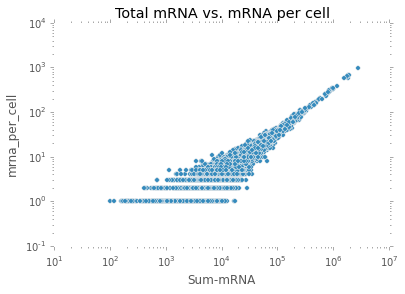

In [418]:
ax = ribo_profiling[ribo_profiling.mrna_per_cell > 0].plot("Sum-mRNA","mrna_per_cell", 
                                                      kind="scatter", 
                                                      loglog=True,
                                                      title = "Total mRNA vs. mRNA per cell"
                                                     )
ribo_profiling.loc[ribo_profiling.mrna_per_cell > 0,["Sum-mRNA", "mrna_per_cell"]].corr()

In [603]:
compare = results.join(ribo_profiling)

In [604]:
compare

,ribosome_count,mrna_count,max_ribos,mrna_length,#Name,Length,Sum-mRNA,Sum-FP,mrna_per_cell
YBR177C,17,10,5,1356,YBR177C,452,15536,2975,9
YIL140W,2,1,2,2472,YIL140W,824,5989,2240,6
YLR268W,0,3,0,645,YLR268W,215,15105,2269,7
YIR004W,15,9,3,1299,YIR004W,433,20030,2701,7
YAL008W,0,3,0,597,YAL008W,199,6247,1218,3
YOR043W,26,17,3,1461,YOR043W,487,41616,2016,23
YJL122W,5,10,2,528,YJL122W,176,26726,2894,9
YCR093W,70,10,13,6327,YCR093W,2109,24422,7239,7
YLR244C,32,28,4,1164,YLR244C,388,68495,15777,27
YPL144W,2,3,1,447,YPL144W,149,6163,540,2


In [605]:
compare["FP_rpm"] = compare["Sum-FP"]/(compare["Sum-FP"].sum()/1e6)
compare["mRNA_rpkm"] = compare["Sum-mRNA"]/(compare["Length"]/1000)/(compare["Sum-mRNA"].sum()/1e6)

In [606]:
compare["ribo_density"] = compare["FP_rpm"]/compare["mRNA_rpkm"]/compare.Length
compare["ribo_density_sim"] = compare.ribosome_count/compare.mrna_count/compare.Length

In [607]:
compare.head()

,ribosome_count,mrna_count,max_ribos,mrna_length,#Name,Length,Sum-mRNA,Sum-FP,mrna_per_cell,FP_rpm,mRNA_rpkm,ribo_density,ribo_density_sim
YBR177C,17,10,5,1356,YBR177C,452,15536,2975,9,123.165124,279.697761,0.000974,0.003761
YIL140W,2,1,2,2472,YIL140W,824,5989,2240,6,92.736094,59.144629,0.001903,0.002427
YLR268W,0,3,0,645,YLR268W,215,15105,2269,7,93.936695,571.703015,0.000764,0.000000
YIR004W,15,9,3,1299,YIR004W,433,20030,2701,7,111.821513,376.427432,0.000686,0.003849
YAL008W,0,3,0,597,YAL008W,199,6247,1218,3,50.425251,255.450432,0.000992,0.000000


In [608]:
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", 'r'))
init_rates = pd.DataFrame(pd.Series(init_rates), columns=["init_rates"])
compare = compare.join(init_rates)

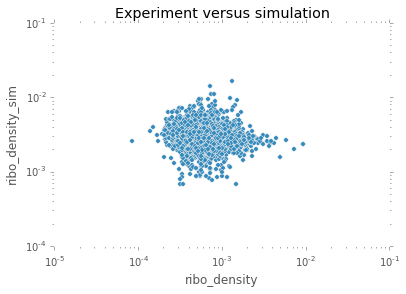

In [609]:
ax = compare[compare.ribosome_count > 0].plot("ribo_density","ribo_density_sim", 
                                         kind="scatter", 
                                         loglog=True, 
                                         title = "Experiment versus simulation"
                                        )
#ax.set_ylabel("Ribosomes per mRNA (simulation)")
#ax.set_xlabel("Ribosomes per mRNA (experiment)")

array([[ 1.        ,  0.96078432,  0.92156863,  1.        ],
       [ 1.        ,  0.96078432,  0.92156863,  1.        ],
       [ 1.        ,  0.96078432,  0.92156863,  1.        ],
       ..., 
       [ 0.49803922,  0.15294118,  0.01568628,  1.        ],
       [ 0.49803922,  0.15294118,  0.01568628,  1.        ],
       [ 0.49803922,  0.15294118,  0.01568628,  1.        ]])

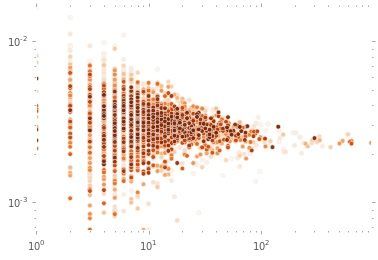

In [650]:
import matplotlib.cm as cm
compare_sorted = compare.sort("Length")[compare.ribosome_count > 0]
colors = cm.Oranges(np.linspace(0, 1, compare_sorted.shape[0]))  # @UndefinedVariable
#colordict = {j: colors[i] for i, j in enumerate(compare.Length)}
fig = plt.figure()
ax = plt.gca()
ax.scatter(compare_sorted["mrna_count"], 
            compare_sorted["ribo_density_sim"], 
            c=colors)
#ax.set_alpha(0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([min(compare_sorted["mrna_count"]), max(compare_sorted["mrna_count"])])
ax.set_ylim([min(compare_sorted["ribo_density_sim"]), max(compare_sorted["ribo_density_sim"])])
colors

In [641]:
colordict

{37: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 39: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 52: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 56: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 57: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 60: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 61: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 62: array([ 1.        ,  0.96078432,  0.92156863,  1.        ]),
 63: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 67: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 68: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 70: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 71: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 74: array([ 0.99987697,  0.95893887,  0.91800077,  1.        ]),
 76: array([ 0.99975394,  0.95709343,  0.91443292,  1.        ]),
 78: array

In [ ]:
plt.scatter()

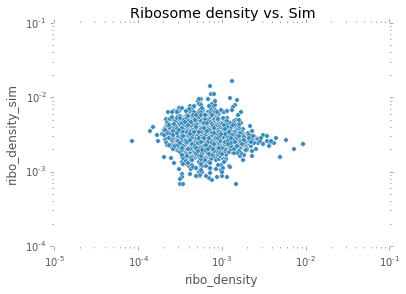

In [577]:
ax = compare[compare.ribosome_count > 0].plot("ribo_density", "ribo_density_sim",
                                         kind="scatter", 
                                         loglog=True, 
                                         title = "Ribosome density vs. Sim")

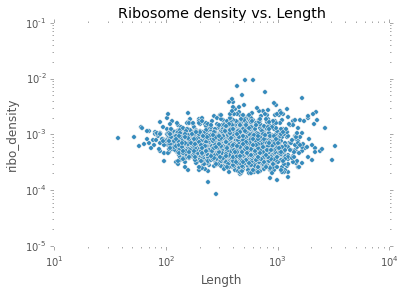

In [552]:
ax = compare[compare.ribosome_count > 0].plot("Length", "ribo_density",
                                         kind="scatter", 
                                         loglog=True, 
                                         title = "Ribosome density vs. Length")

In [665]:
compare = compare.drop(["mrna_length", "#Name","max_ribos"], axis=1)

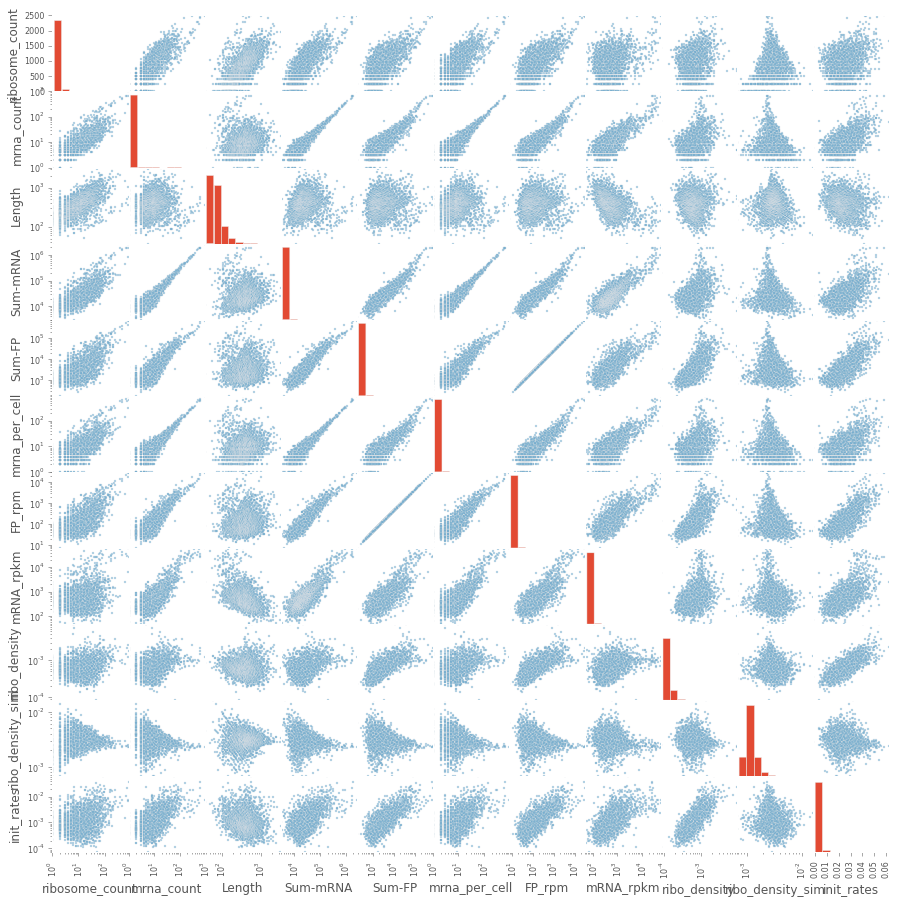

In [668]:
compare_filtered = compare[compare.ribosome_count > 0]
s = pd.scatter_matrix(compare_filtered, figsize=(15,15))
for i, axs in enumerate(s):
    for j, ax in enumerate(axs):
        if i != j:  # only the scatter plots
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim([min(compare_filtered.ix[:,j]), max(compare_filtered.ix[:,j])])
            ax.set_ylim([min(compare_filtered.ix[:,i]), max(compare_filtered.ix[:,i])])